<a href="https://colab.research.google.com/github/Mrsnellek/MSDS_686_22F8W2/blob/23S8W1/MSDS%20686/Week_6/Week_6_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis Assignment
## Adapted from Deep Learning with Python (2021)

In [1]:
#from IPython.core.display import display, HTML
#isplay(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import shutil
import string
import tensorflow as tf
from keras import models, layers, backend, Input, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import TextVectorization, IntegerLookup, Bidirectional, LSTM
from keras.utils import text_dataset_from_directory
from sklearn.model_selection import train_test_split

np.random.seed(1)

Download and extract the data.

In [13]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  6004k      0  0:00:13  0:00:13 --:--:-- 5553k99k      0  0:00:13  0:00:10  0:00:03 5902k


In [14]:
!tar -xf aclImdb_v1.tar.gz

We will removed the unneeded unsup directory

In [15]:
!rm -r aclImdb/train/unsup
!rm aclImdb_v1.tar.gz

We will create a validation folder with validation images from the training images


In [19]:
for category in ("neg", "pos"):
  os.makedirs("aclImdb/val/" + category)
  files = os.listdir("aclImdb/train/" + category)
  np.random.shuffle(files)
  num_val_samples = int(0.2*len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move("aclImdb/train/" + category + "/" + fname,
                "aclImdb/val/" + category + "/" + fname)

Just like with our image data we will use flow from directory so we are not using too much memory

In [21]:
batch_size = 32
train_flow = text_dataset_from_directory("aclImdb/train", batch_size = batch_size)
val_flow = text_dataset_from_directory("aclImdb/val", batch_size = batch_size)
test_flow = text_dataset_from_directory("aclImdb/test", batch_size = batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.



We can inspect the first element of data flowing from the training directory

In [22]:
(x, y) = next(iter(train_flow))

print("input shape: ", x.shape)
print("input type: ", x.dtype)
print("targets shape: ", y.shape)
print("targets type: ", y.dtype)
print("x[0] input text: ", x[0])
print("y targets: ", y)

input shape:  (32,)
input type:  <dtype: 'string'>
targets shape:  (32,)
targets type:  <dtype: 'int32'>
x[0] input text:  tf.Tensor(b"This is Not a Love Song.<br /><br />My one word summary of this film would be `Excellent'.<br /><br />It probably won't appeal to the mass movie watching public \xc2\x96 it's a<br /><br />film that forces you to participate. You observe, think, and question.<br /><br />Comparisons could be made with Deliverance (Topic/Theme) and<br /><br />perhaps with The Blair Witch Project for overall filming style.<br /><br />However this film stands unique against both.<br /><br />The cinematography effects (solarisation, freeze frame, blur etc)<br /><br />have been seen before but they are used most effectively in this<br /><br />film to underpin the natural tension of the story.<br /><br />Acting is raw, menacing and utterly believable.<br /><br />The real theme of the film is about friendship; the title really gives<br /><br />the game away. It's probably not th

There is some puncuation and `<br /><br />` values that we should remove.  The below function will remove those features.

In [27]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    #stripped_html = tf.strings.regex_replace(lowercase, "\n", " ")

    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

In [ ]:
check_train = train_flow.map(lambda x, y: (custom_standardization(x), y))
(x, y) = next(iter(check_train))
print("x input text: ", x[0])

Now we will work on vectorizing the `x` text data.  We will define the number of most common tokens, words, or n-grams that we will use to build our model.  Below, we will start with the 20000 most common words or n-grams.  This will make sure we are not modeling on spelling mistakes or words that only appear once in the data -- in other words, we do not want to model 'noise'.

In [30]:
# This removes the y targets.  
text_only_train = train_flow.map(lambda x, y: x)

Now that we have removed the `y` targets from the data and removed punctuation and HTML tags, we can begin to vectorize the data. We will choose 20,000 of the most common words or n-grams.  We will normalize the output using [TF-IDF](https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558) normalization methods.

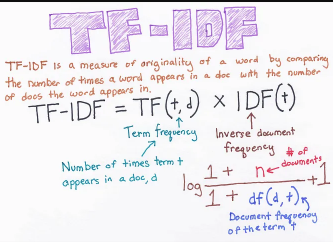

In [31]:
max_tokens = 20000
text_vectorization = TextVectorization(
    standardize = custom_standardization,
    ngrams = 2,
    max_tokens = max_tokens,
    output_mode = 'tf_idf'
)

In [32]:
# This will create a vector that we will use to index our text inputs with values 
# between 0 and 20,000.
text_vectorization.adapt(text_only_train)
vocab = text_vectorization.get_vocabulary()
vocab[100:125]

['him',
 'most',
 'it was',
 'dont',
 'made',
 'then',
 'one of',
 'for the',
 'movies',
 'them',
 'way',
 'films',
 'with the',
 'of a',
 'make',
 'too',
 'any',
 'could',
 'after',
 'characters',
 'think',
 'is the',
 'as a',
 'watch',
 'at the']

In [15]:
# Appy text_vecorization to the x input text data, but not the y targets
tfidf_train = train_flow.map(lambda x, y: (text_vectorization(x), y))
tfidf_val = val_flow.map(lambda x, y: (text_vectorization(x), y))
tfidf_test = test_flow.map(lambda x, y: (text_vectorization(x), y))

Now we apply the `text_vectorization` to each of the `x` text inputs as they flowed from our directories.  Below, you can see the outputs.  The `x` data is now vectorized and there is a normalized TF-IDF value for each word or n-gram found in the text.

In [ ]:
(x, y) = next(iter(tfidf_train))
print("input shape: ", x.shape)
print("input type: ", x.dtype)
print("targets shape: ", y.shape)
print("targets type: ", y.dtype)
print("x input text: ", x[0])
print("y target: ", y)

input shape:  (32, 20000)
input type:  <dtype: 'float32'>
targets shape:  (32,)
targets type:  <dtype: 'int32'>
x input text:  tf.Tensor(
[4380.5317     62.070778   21.332792 ...    0.          0.
    0.      ], shape=(20000,), dtype=float32)
y target:  tf.Tensor([1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0], shape=(32,), dtype=int32)


Now we can build our model

In [17]:
def text_model():
  backend.clear_session()
  model = models.Sequential()
  model.add(layers.Dense(16, activation = 'relu', input_shape = (max_tokens,)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'rmsprop',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])
  return model

Now we apply our model to the data.

In [18]:
model = text_model()
model.fit(tfidf_train, validation_data = tfidf_val, 
          epochs = 10, 
          callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)])
model.evaluate(tfidf_test)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7175 - loss: 0.7574 - val_accuracy: 0.8918 - val_loss: 0.3063
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8719 - loss: 0.3201 - val_accuracy: 0.9022 - val_loss: 0.2959
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8902 - loss: 0.2710 - val_accuracy: 0.8860 - val_loss: 0.3192
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9021 - loss: 0.2400 - val_accuracy: 0.8856 - val_loss: 0.3381
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9015 - loss: 0.2395 - val_accuracy: 0.8696 - val_loss: 0.3366
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8882 - loss: 0.2987


[0.2973167300224304, 0.888159990310669]

The above model was a bag-of-words approach with 2-grams.  The bag-of-words approach does not consider the word order beyond the 2-grams. Now we will add an embedding layer which turns [one-hot-encoded](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics) words into dense "word vectors" or "[word embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)".  We will also add an [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) layer for added word-order awareness.

Our word vectors will be 128-dimensional -- much more reasonable than 20,000!

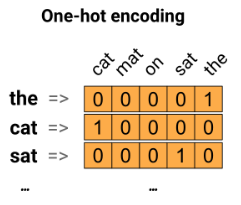 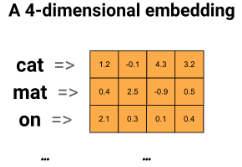

In [19]:
max_length = 600        # Maximum allowable length of an input document (in tokens)
max_tokens = 20000
text_embedding = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_tokens,
    output_mode = 'int',
    output_sequence_length = max_length
)

In [20]:
# This will create a vector that we will use to index our text inputs with values 
# between 0 and 20,000.
text_embedding.adapt(text_only_train)

In [21]:
embed_train = train_flow.map(lambda x, y: (text_embedding(x), y))
embed_val = val_flow.map(lambda x, y: (text_embedding(x), y))
embed_test = test_flow.map(lambda x, y: (text_embedding(x), y))

In [22]:
(x, y) = next(iter(embed_train))
print("input shape: ", x.shape)
print("input type: ", x.dtype)
print("targets shape: ", y.shape)
print("targets type: ", y.dtype)
print("x input text: ", x[0])
print("y input text: ", y)

input shape:  (32, 600)
input type:  <dtype: 'int64'>
targets shape:  (32,)
targets type:  <dtype: 'int32'>
x input text:  tf.Tensor(
[   11     7   233    28     5     2   241   777    92    10    25   104
    37   235   776    50    70  1282   777    92    10    25   121   104
   373   833     3    51     1   112  2754     2   929 14866    16    31
    12     9   145   546    86   314  1023   777   133     3  3682   223
    68   740     6     2    63    28     5     2  1446  5209     5    11
    17     7    12   131   106   101    84    21  5796    79    14    33
   304    10    89   448    48   551     6    93     9  2780    69    86
    11    17  1133  6850  4557     8  7126   132    10   116   212    31
     2  7819    92     8  7126    18    21    11    28     4   673  1343
    15    69     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0   

In [ ]:
backend.clear_session()
# Build a model using the Functional API
inputs = Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_tokens, 128) (inputs) # Here we will learn the word emdeddings
x = layers.Bidirectional(layers.LSTM(32)) (x)
x = layers.Dropout(0.5) (x)
x = layers.Dense(64, activation="relu") (x)
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(1, activation = 'sigmoid') (x)
model = Model(inputs, outputs)
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,605,441 (9.94 MB)

 Trainable params: 2,605,441 (9.94 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.fit(embed_train, validation_data = embed_val, 
          epochs = 10, 
          callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)])
model.evaluate(embed_test)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 168ms/step - accuracy: 0.6066 - loss: 0.6351 - val_accuracy: 0.8522 - val_loss: 0.3578
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 178ms/step - accuracy: 0.8418 - loss: 0.4041 - val_accuracy: 0.8494 - val_loss: 0.3468
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 110s 177ms/step - accuracy: 0.8780 - loss: 0.3334 - val_accuracy: 0.8422 - val_loss: 0.3953
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 179ms/step - accuracy: 0.8974 - loss: 0.2789 - val_accuracy: 0.8804 - val_loss: 0.3264
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 178ms/step - accuracy: 0.9164 - loss: 0.2336 - val_accuracy: 0.7910 - val_loss: 0.6111
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 178ms/step - accuracy: 0.9304 - loss: 0.2080 - val_accuracy: 0.8620 - val_loss: 0.4490
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 110s 175ms/step - accuracy: 0.9416 - loss: 0.1797 - val_accuracy: 0.8784 - val_loss: 0.5004
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8731 - loss: 0.3483

[0.34394070506095886, 0.8714799880981445]

Word embeddings and LSTM models can  inprove text models. You can also use pretrained word embeddings such as [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) or [word2vec](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/rvecs.pdf).  Using these pretained embeddings will decrease run time and likely increase accuracy.

The *Transformer* model architecure began being favored over *recurrent neural networks* (RNNs) starting in 2017. Here is the [seminal paper](https://arxiv.org/pdf/1706.03762.pdf) that introduced transformer neural networks.

We will not cover Transformers this week but you are welcome to explore and utilize transformers in your assignment.


# Your turn

Your assignment is to download and perform sentiment classification of coronavirus-related tweets.  The [dataset](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification) is part of a Kaggle competition.  You will need to download the Kaggle API JSON file and upload it to Google Colab.  I have provided the code you need to download, unzip, and organize the tweets so you can perform NLP classification.

In [3]:
# Download and innsall Kaggle package
! pip install kaggle -q

In [4]:
# Make a Kaggle dirrectory
! mkdir ~/.kaggle

mkdir: /Users/johnxie301/.kaggle: File exists


#### Upload your kaggle.json API file

In [38]:
# Copy your kaggle.json file to the newly created Kaggle folder
! cp kaggle.json ~/.kaggle/

cp: kaggle.json: No such file or directory


In [39]:
# Change permission of the the .json file.
! chmod 600 ~/.kaggle/kaggle.json

chmod: /Users/johnxie301/.kaggle/kaggle.json: No such file or directory


In [40]:
# Download the dataset
! kaggle datasets download -d datatattle/covid-19-nlp-text-classification

Dataset URL: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification
License(s): copyright-authors
covid-19-nlp-text-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Load the .csv datasets.  View the number of tweets in each file. 
cv_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
cv_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')
print(len(cv_train))
print(len(cv_test))
print(cv_train.head())
print(cv_train['Sentiment'].unique())

41157
3798
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  
['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


We will simplify the problem by creating 3 classes: positive, neutral, and negative.

In [6]:
cv_train['Sentiment']=cv_train['Sentiment'].replace('Extremely Positive','Positive')
cv_train['Sentiment']=cv_train['Sentiment'].replace('Extremely Negative','Negative')

cv_test['Sentiment']=cv_test['Sentiment'].replace('Extremely Positive','Positive')
cv_test['Sentiment']=cv_test['Sentiment'].replace('Extremely Negative','Negative')

In [7]:
# Create CV train and validation folders
for category in cv_train['Sentiment'].unique():
  os.makedirs("cv/train/" + category)
  os.makedirs("cv/val/" + category)

FileExistsError: [Errno 17] File exists: 'cv/train/Neutral'

In [46]:
# Place each tweet into each folder as a .txt file
i = 0
for category in cv_train['Sentiment'].unique():
  for tweet in cv_train['OriginalTweet'].loc[cv_train['Sentiment'] == category]:
      with open("cv/train/" + category + "/" + str(i) + ".txt", 'w', encoding='utf-8') as my_tweet:
        i +=1
        my_tweet.write(tweet)

In [47]:
# Split 20% of the training tweets into respective validataion folders.
for category in cv_train['Sentiment'].unique(): 
  files = os.listdir("cv/train/" + category)
  np.random.shuffle(files)
  num_val_samples = int(0.2*len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move("cv/train/" + category + "/" + fname,
                "cv/val/" + category + "/" + fname)

In [48]:
# Place each test tweet into each folder as a .txt file
for category in cv_test['Sentiment'].unique():
  os.makedirs("cv/test/" + category)
i = 0
for category in cv_test['Sentiment'].unique():
  for tweet in cv_test['OriginalTweet'].loc[cv_test['Sentiment'] == category]:
      with open("cv/test/" + category + "/" + str(i) + ".txt", 'w', encoding='utf-8') as my_tweet:
        i +=1
        my_tweet.write(tweet)

In [8]:
# Sanity check that files are in correct folders.
batch_size = 32
cv_train_flow = text_dataset_from_directory("cv/train", batch_size = batch_size, label_mode = 'categorical')
cv_val_flow = text_dataset_from_directory("cv/val", batch_size = batch_size, label_mode = 'categorical')
cv_test_flow = text_dataset_from_directory("cv/test", batch_size = batch_size, label_mode = 'categorical')

Found 32927 files belonging to 3 classes.
Found 8230 files belonging to 3 classes.
Found 3798 files belonging to 3 classes.


### Continue creating a model to classify the tweets into the 3 different categories.  You can try a pretrained word embeding layer, n-grams, TF-IDF, LSTM, removing stopwords, depth, sequence length, etc. Think about how you will clean the tweets and remove special characters and character artifacts.

## Using GloVe

In [53]:
# trying GloVe, download
!rm -f glove.6B.zip


#### 
Download Glove embeddings. Was going to do it the easy way but somehow failed, so I asked GPT for help. The follow two cells are suggested by GPT:

In [54]:
import requests

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"

print("Downloading GloVe embeddings...")

response = requests.get(glove_url, stream=True)
with open(glove_zip, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        file.write(chunk)

print("Download complete!")


Download complete!


In [55]:
import zipfile

if zipfile.is_zipfile(glove_zip):
    print("Valid ZIP file, ready to extract!")
else:
    print("Download is corrupted. Try downloading again.")


Valid ZIP file, ready to extract!


In [56]:
import zipfile

with zipfile.ZipFile(glove_zip, "r") as zip_ref:
    zip_ref.extractall("glove")

print("GloVe embeddings extracted successfully!")


GloVe embeddings extracted successfully!


#### 
Formating and Loading Data

In [9]:
import os

# Define folder paths
base_dir = "/Users/johnxie301/Downloads/cv"  # Change to your actual directory
folders = ["train", "val", "test"]
categories = ["Negative", "Neutral", "Positive"]

# Function to load data
def load_text_data(folder):
    texts, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(base_dir, folder, category)
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            with open(file_path, "r", encoding="utf-8") as f:
                texts.append(f.read().strip())  # Read text
                labels.append(label)  # Assign label
    return texts, labels

# Load train, val, and test data
train_texts, train_labels = load_text_data("train")
val_texts, val_labels = load_text_data("val")
test_texts, test_labels = load_text_data("test")

print("Sample Train Text:", train_texts[0])
print("Corresponding Label:", train_labels[0])


Sample Train Text: Today's lockdowns will ease at some point, though it's unclear when. Perhaps even more uncertain is what the mindsets of erstwhile customers will be. https://t.co/YV0gd391K0
Corresponding Label: 0


In [10]:
# check training data size
print(len(train_texts))

32927


In [11]:
#check max length for singles texts
max_length = max(len(s) for s in train_texts)
print(max_length)
max_length = max(len(s) for s in val_texts)
print(max_length)
max_length = max(len(s) for s in test_texts)
print(max_length)


344
326
340


Comment: Unnecessary step, These are number of strings not number of words......

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

####
Tokenization

In [21]:
vocab_size = 32927  # Adjust based on dataset size
max_length = 300   # Max words per sentence
oov_token = "<OOV>"  # Token for unknown words


# Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_texts)  # Fit only on training data

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

# Convert labels to TensorFlow format
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
test_labels = tf.convert_to_tensor(test_labels)

print("Padded Train Sample:", train_padded[0])


Padded Train Sample: [ 2058  1597    42  2389    22    85   589   820   173  8936    82  1546
   153    51  1715    15    68     2 21193     8 21194   176    42    32
     7     4     6 21195     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0

In [22]:
# Create TensorFlow Datasets
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_padded, train_labels)).shuffle(len(train_texts)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_padded, val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_padded, test_labels)).batch(batch_size)


In [25]:
# Model Definition
backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  # Reduce dimensionality
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 categories -> softmax activation
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3,  # Wait for 3 epochs without improvement
                           restore_best_weights=True)

In [28]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Adjust as needed
    callbacks = [early_stop]
)

# Plot training & validation loss
plt.figure(figsize=(12, 6))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4537 - loss: 1.0363 - val_accuracy: 0.4678 - val_loss: 1.0622
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6243 - loss: 0.8474 - val_accuracy: 0.5662 - val_loss: 1.0636
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6921 - loss: 0.7266 - val_accuracy: 0.5829 - val_loss: 0.9478
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7173 - loss: 0.6669 - val_accuracy: 0.6130 - val_loss: 0.9084
Epoch 5/10
  33/1029 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7817 - loss: 0.5735

KeyboardInterrupt: 

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")


In [16]:
# Load GloVe embeddings
glove_path = "/Users/johnxie301/Downloads/glove/glove.6B.300d.txt"  # Using 300D embeddings
embedding_dim = 300

# Create dictionary mapping words to vectors
embeddings_index = {}

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]  # First value is the word
        vector = np.asarray(values[1:], dtype='float32')  # Rest are embedding values
        embeddings_index[word] = vector

print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


In [29]:
# Create embedding matrix
vocab_size = 400000  # Keep same as tokenizer
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill matrix with GloVe vectors (if available)
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Use GloVe vector
        else:
            embedding_matrix[i] = np.random.normal(size=(embedding_dim,))  # Random init for missing words

print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (400000, 300)


In [42]:
# Define model using pretrained GloVe embeddings
backend.clear_session()

model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=True))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(64, activation='relu'))
#model.add(LSTM(64, return_sequences=True))  # First LSTM layer
model.add(layers.Dense(3, activation = 'softmax'))
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   120,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,000,000 (457.76 MB)

 Trainable params: 120,000,000 (457.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000000 elements. This may consume a large amount of memory.
  warnings.warn(


1029/1029 ━━━━━━━━━━━━━━━━━━━━ 163s 158ms/step - accuracy: 0.5013 - loss: 0.9867 - val_accuracy: 0.4893 - val_loss: 1.0472
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 162s 158ms/step - accuracy: 0.6419 - loss: 0.8145 - val_accuracy: 0.5716 - val_loss: 0.9991
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 163s 158ms/step - accuracy: 0.6877 - loss: 0.7330 - val_accuracy: 0.5738 - val_loss: 0.9364
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 162s 157ms/step - accuracy: 0.7264 - loss: 0.6572 - val_accuracy: 0.6176 - val_loss: 0.8568
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 162s 157ms/step - accuracy: 0.7482 - loss: 0.6034 - val_accuracy: 0.6222 - val_loss: 0.8422
Epoch 6/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 162s 157ms/step - accuracy: 0.7640 - loss: 0.5700 - val_accuracy: 0.5210 - val_loss: 0.9984
Epoch 7/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 162s 157ms/step - accuracy: 0.7877 - loss: 0.5241 - val_accuracy: 0.6156 - val_loss: 0.8399
Epoch 8/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 166s 161ms/step - accuracy: 0.8

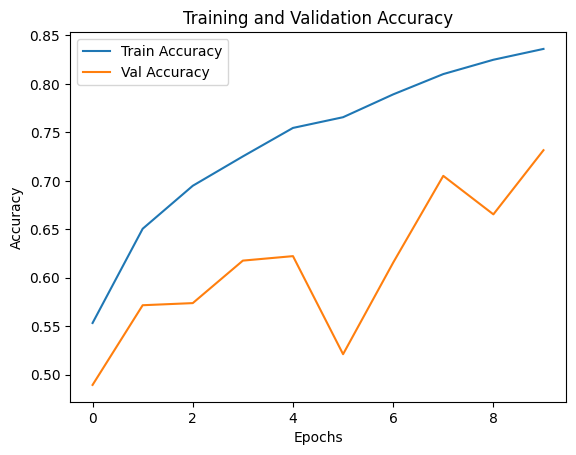

In [43]:
# Train model
history = model.fit(train_dataset, 
                    validation_data=val_dataset,
                    epochs=10,
                    callbacks = [early_stop])

# graph the training and validating accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [44]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6128 - loss: 0.9107
Test Accuracy: 0.71


## Summary:

This week I took more time learning the concepts of the assignment and a lot of thoughts were derived as I learned more. The best result I got with using pretrained GloVe embedings is fun. Each time the model takes a lot of time to run. But seeing updates on val accuracy is a great thing. I did not fine-tune it to the best, not even to this ones max potential. The accuracy can go up with more epochs. I will make an update on this assignment later this coming week if that's ok. 